#                                                                            CURTIS AMO DWIRA   ------------- GEOG4057 ASSIGNMENT 7

# Part 1: Raster Basics and Properties

## Raster Dataset preparation

### Defining Folder Path and Workspace

In [1]:
import arcpy
arcpy.CheckOutExtension('Spatial')
arcpy.CheckOutExtension('ImageAnalyst')
from arcpy.sa import *
from arcpy.ia import *
import numpy as np
import os

arcpy.env.workspace = r"C:\Users\cdwira1\Downloads\GEOG4057\Curtis_Dwira\Assignment_7\Ex7"
arcpy.env.overwriteOutput = True

### Creating a List for the Raster dataset using arcpy.Walk() to List all the raster Datasets in the Folder

In [2]:
raster_list = []
for dirpath, dirnames, filenames in arcpy.da.Walk(arcpy.env.workspace, datatype="RasterDataset"):
    for filename in filenames:
        raster_list.append(os.path.join(dirpath, filename))

raster_list



['C:\\Users\\cdwira1\\Downloads\\GEOG4057\\Curtis_Dwira\\Assignment_7\\Ex7\\elevation',
 'C:\\Users\\cdwira1\\Downloads\\GEOG4057\\Curtis_Dwira\\Assignment_7\\Ex7\\landcover.tif',
 'C:\\Users\\cdwira1\\Downloads\\GEOG4057\\Curtis_Dwira\\Assignment_7\\Ex7\\tm.img']

### Basic Properties

In [3]:
for raster in raster_list:
    ras = arcpy.Raster(raster)
    print(f"Raster: {ras.name}")
    print(f"Band Count: {ras.bandCount}")
    print(f"Cell Size: {ras.meanCellWidth} x {ras.meanCellHeight}")
    print(f"Bit Depth: {ras.pixelType}")
    print(f"Spatial Reference: {ras.spatialReference.name}")
    print("-" * 50)


Raster: elevation
Band Count: 1
Cell Size: 30.0 x 30.0
Bit Depth: F32
Spatial Reference: NAD_1983_UTM_Zone_13N
--------------------------------------------------
Raster: landcover.tif
Band Count: 1
Cell Size: 30.0 x 30.0
Bit Depth: S8
Spatial Reference: NAD_1983_UTM_Zone_13N
--------------------------------------------------
Raster: tm.img
Band Count: 3
Cell Size: 0.00027777799999999665 x 0.0002777779999999973
Bit Depth: U8
Spatial Reference: GCS_North_American_1983
--------------------------------------------------


The first two rasters (elevation and landcover.tif) are in projected UTM coordinates, ideal for spatial analysis.
The tm.img is in a geographic coordinate system, so reprojection might be required when combining with others


# Part 2: Raster Analysis

### Slope Analysis:

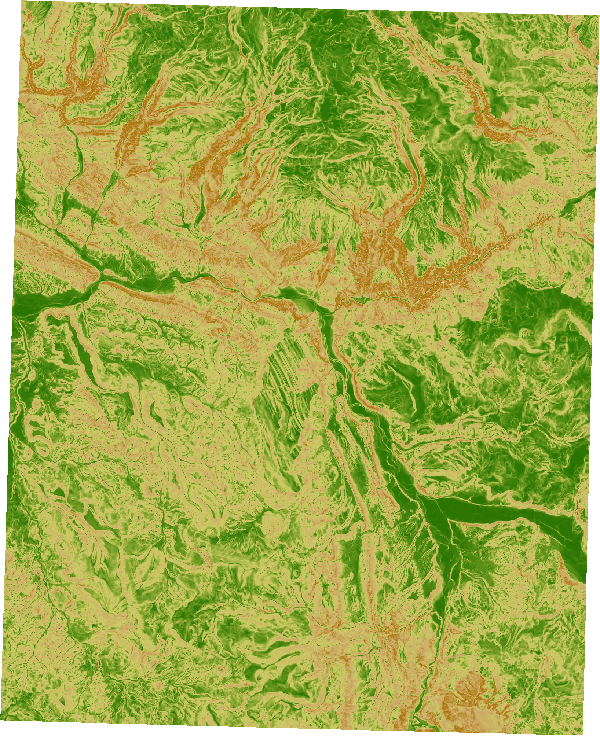

In [4]:
from arcpy.sa import *

elevation = Raster("elevation")
slope_raster = Slope(elevation)
slope_raster.save("slope_output.tif")
Render(slope_raster,colormap="Elevation #9")


The Render was used to render the raster output to provide automatic contrast stretchingor color ramp visualisation helping the user to interpret the result spatial analysis operations.

### Clipping Operation

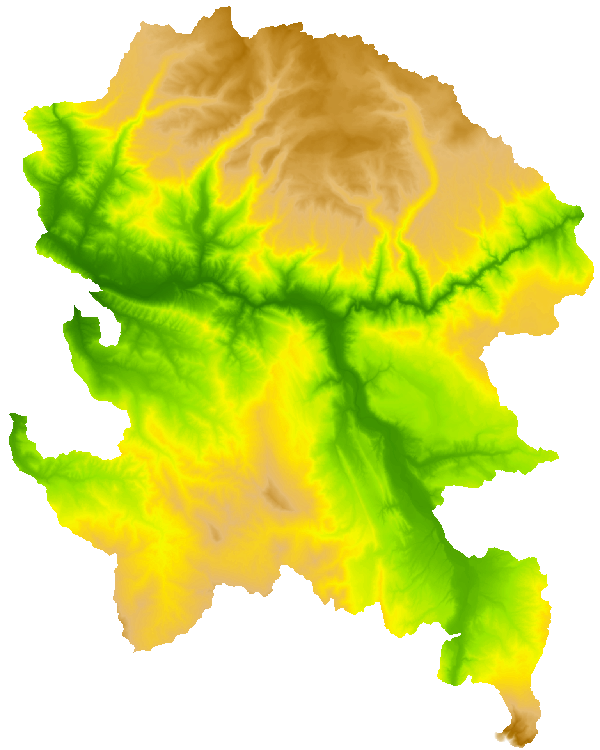

In [5]:
clip_feature = "watershed_HUC12.shp"
clipped = ExtractByMask(elevation, clip_feature)
clipped.save("elevation_clipped.tif")

clipped
Render(clipped,colormap="Elevation #10")


The clipping operation extracts only the area of interest (watershed), reducing unnecessary data and focusing the analysis. This operation is essential for hydrological modeling, runoff simulation, and watershed management. From the image high elevation and low elevation within the watershed are now distinguishable.

## Part 3: Raster Manipulation



### Map Algebra Operators

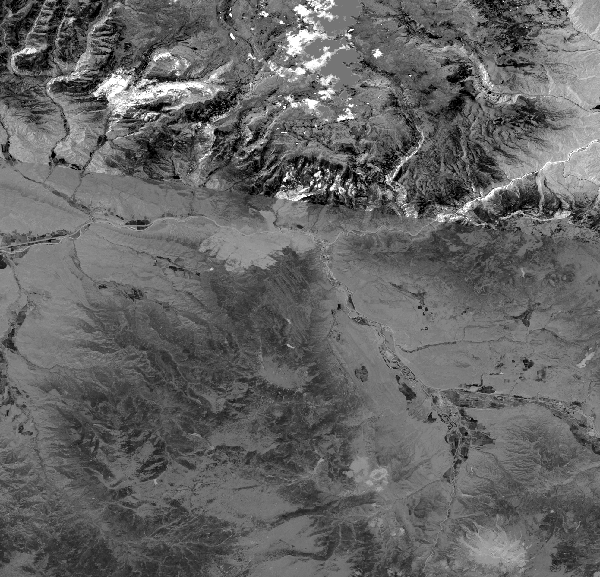

In [6]:

# Access Band 1 and Band 3 of the multiband raster (indexing starts at 1 here)
band3 = arcpy.Raster('tm.img/Layer_3')
band1 = arcpy.Raster('tm.img/Layer_1')
# Compute vegetation index (custom formula)
index = (band3 - band1) / ((band3 + band1))

index_scaled = ((index - index.minimum) / (index.maximum - index.minimum)) * 255
index_scaled.save("veg_index_scaled.tif")
index





The index was scaled to a 0–255 range to enhance visualization. Bright areas indicate higher reflectance in Band 3 compared to Band 1. These could represent reflective surfaces such as bare land, dry soil, or possibly built-up areas. Dark areas indicate either dominance of Band 1 or low reflectance in both bands — potentially vegetation, water bodies, or shaded terrain. Gray mid-tones suggest a balance in reflectance and may correspond to transitional land cover types. 

### Raster Cell Iterator

In [7]:
dem = Raster("elevation") # Replace with your input raster
raster_info = dem.getRasterInfo() # Get raster info and set output type

raster_info


In [8]:
# Raster data dimension
cell_x = dem.meanCellWidth
cell_y = dem.meanCellHeight
raster_info.setPixelType("U32")
print(f" cell_x: {cell_x} and cell_y: {cell_y}")

 cell_x: 30.0 and cell_y: 30.0


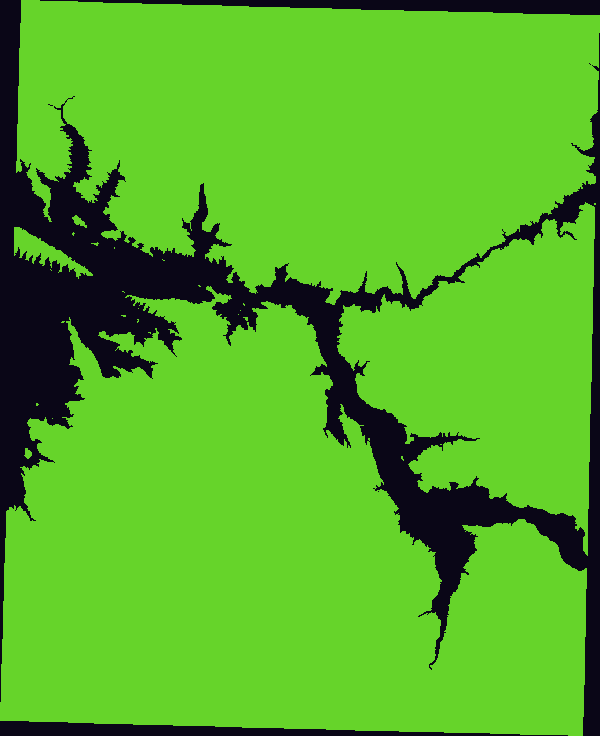

In [10]:
# Create output raster
elev_reclass = Raster(raster_info)

# Using RasterCellIterator to iterate over pixel
with RasterCellIterator({'rasters':[dem, elev_reclass]}) as rci:
    for r, c in rci:
        elev_value = dem[r, c]  # Access the cell value using indexing
        elev_reclass[r, c] = 1 if elev_value > 2000 else 0 # Set cell value using indexing

# Save result
elev_reclass.save("elev_reclass.tif")
elev_reclass


The RasterCellIterator is one of the powerful tools in the ArcGIS Spatial Analyst module that allows you to access and modify individual cells within raster datasets using programming. It used in performing cell based raster analysis, and implemented in tasks which is not easily accomplished with standard geoprocessing tools. It provides cell by cell iteration  which let you loop through each pixel in a raster datset. Individual  is able to access the cell value at each location and write new values to the same or another raster

## Part 4: NumPy and Raster Integration

### NumPy Array Conversion

In [11]:
# Get the NoData value from the raster
no_data_value = dem.noDataValue

# Convert the raster to a NumPy array, explicitly setting the NoData value to nan
elev_array = arcpy.RasterToNumPyArray(dem, nodata_to_value = np.nan)

# Calculate raster statistics using NumPy
min_val = np.nanmin(elev_array)
max_val = np.nanmax(elev_array)
mean_val = np.nanmean(elev_array)
std_val = np.nanstd(elev_array)


In [12]:
# Print the statistics
print(f"Minimum: {min_val}")
print(f"Maximum: {max_val}")
print(f"Mean: {mean_val}")
print(f"Standard Deviation: {std_val}")

Minimum: 1655.9979248046875
Maximum: 3942.435302734375
Mean: 2515.250244140625
Standard Deviation: 435.5968933105469


## Discuss the advantages and applications of using NumPy arrays for raster data processing in GIS.

### Advantages

- NumPy arrays store elements of the same data type contiguously in memory. This is more memory-efficient than Python lists, especially for large raster datasets.

- NumPy supports vectorized operations, which apply operations to entire arrays without explicit loops. Vectorization significantly improves performance and reduces code complexity.

- NumPy arrays can represent and efficiently manipulate multi-dimensional data, such as multiband raster imagery, and simplifies operations like band arithmetic and filtering.

### Applications

- In Raster analysis, numpy is used to perform map algebra and arithmetic operations on raster bands, reclassifying and calculating statistics and other summary operations.
- In image processing, numpy used in filtering and raster images enhancement.
- In geospatial modeling and analysis, numpy is used for terrain analysis, hydrological and spatial interpolation